# House Price Regression


In [25]:
import numpy as np                    # Linear algebra 
import pandas as pd                   # Data Processing
from matplotlib import pyplot as plt  # Matlab-style ploting

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

#Ignoring warnings
import warnings
def ignore_warn(*args, **kwargs):
 pass
warnings.warn =  ignore_warn


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points



#Import Dataset

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
train = pd.read_csv('/content/drive/My Drive/Kaggle/House Price Prediction/train.csv')
test = pd.read_csv('/content/drive/My Drive/Kaggle/House Price Prediction/test.csv')

# # load the train and test data sets from local disk
# train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
# test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [28]:
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
x_test  = test.iloc[:,:]
#x_test.head()

# Data Analysis

## Structure Analysis

In [29]:
print("train data:", train.shape )
print("test  data :", test.shape )

train data: (1460, 81)
test  data : (1459, 80)


In [30]:
print("x_train data:", x_train.shape )
print("y_train data:", y_train.shape )

x_train data: (1460, 80)
y_train data: (1460, 1)


In [31]:
print("x_test data:", x_test.shape)
## we need to predict y_test

x_test data: (1459, 80)


In [32]:
x_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Correlation Analysis

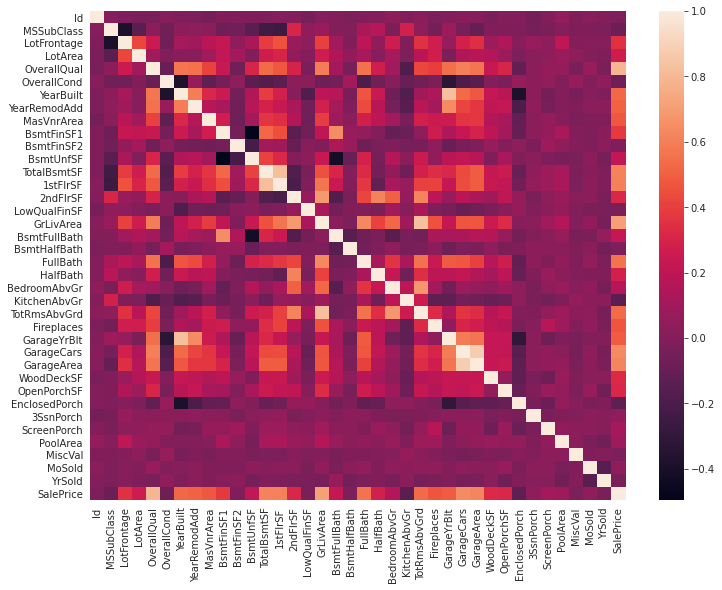

In [33]:
#Correlation map to see how features are correlated
corrmat = train.corr(method='pearson') # pearson or spearman
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, annot=False )

In [34]:
# Correlation values to see how features are correlated with Saleprice
corr_target = corrmat.iloc[:-1,-1:]
corr_target = corr_target.sort_values('SalePrice', ascending=False)
corr_target_positive = corr_target[corr_target.SalePrice >0]
corr_target_negative = corr_target[corr_target.SalePrice <0]
corr_target_zero = corr_target[corr_target.SalePrice == 0]

In [35]:
print("corr_target          :", corr_target.shape)
print("corr_target_positive :", corr_target_positive.shape)
print("corr_target_negative :", corr_target_negative.shape)
print("corr_target_zero     :", corr_target_zero.shape)

corr_target          : (37, 1)
corr_target_positive : (27, 1)
corr_target_negative : (10, 1)
corr_target_zero     : (0, 1)



*   Total numeric features: 37
*   No of features positively correlated with SalePrice: 27
*   No of features negatively correlated with SalePrice 10
*   No of features zero correlated with SalePrice: 0


**Positive Correlated Features**

In [36]:
corr_target_positive

,SalePrice
OverallQual,0.791
GrLivArea,0.709
GarageCars,0.640
GarageArea,0.623
TotalBsmtSF,0.614
1stFlrSF,0.606
FullBath,0.561
TotRmsAbvGrd,0.534
YearBuilt,0.523
YearRemodAdd,0.507


**Negative Correlated Featutes**

In [37]:
corr_target_negative

,SalePrice
BsmtFinSF2,-0.011
BsmtHalfBath,-0.017
MiscVal,-0.021
Id,-0.022
LowQualFinSF,-0.026
YrSold,-0.029
OverallCond,-0.078
MSSubClass,-0.084
EnclosedPorch,-0.129
KitchenAbvGr,-0.136


## Distribution Analysis

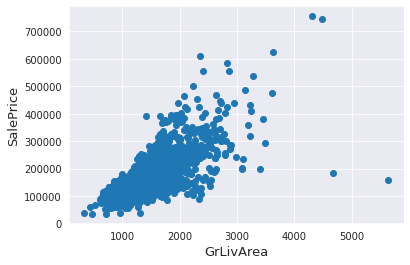

In [38]:
fig, ax = plt.subplots()
ax.scatter(x_train['GrLivArea'], y_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()



*   Data is destributed linearlly, so we can assume sklearn.linear_models suites best.
*   Two outliers that are far away from distribution so we can delete them



##Features Analysis

**Groups**

* LotArea, LotShape, LotConfig
* TotalBsmtSF, 1stFlrSF, 2ndFlrSF
* YearBuilt, YearRemodAdd, YrSold
* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2,BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
* BsmtFullBath, BsmtHalfBath, FullBath, HalfBath
* OpenPorchSF, 3SsnPorch, EnclosedPorch, ScreenPorch, WoodDeckSF
* GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, 

**New Features**

1. **TotalSF** = TotalBsmtSF + 1stFlrSF + 2ndFlrSF

2. **Total_sqr_footage** = BsmtFinSF1+ BsmtFinSF2 + 1stFlrSF + 2ndFlrSF

3. **Total_Bathrooms** = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath'

4. **YrBltAndRemod** = YearBuilt + YearRemodAdd

5. **Total_porch_sf** = OpenPorchSF + 3SsnPorch +                           EnclosedPorch + ScreenPorch + WoodDeckSF

**Delete Features**

1. ID

# Data Preprocessing

## Dependent Feature

### Missing Data

In [39]:
y_train.isnull().sum()

SalePrice    0
dtype: int64

### Outliers

**Check for outliers**

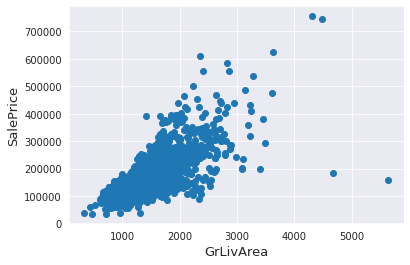

In [40]:
fig, ax = plt.subplots()
ax.scatter(x_train['GrLivArea'], y_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**Delete Outliers**

In [41]:
index = (x_train[(x_train['GrLivArea']>4000) & (y_train['SalePrice']<300000)].index)
x_train = x_train.drop(index)
y_train = y_train.drop(index)
index

Int64Index([523, 1298], dtype='int64')

**Without outliers**

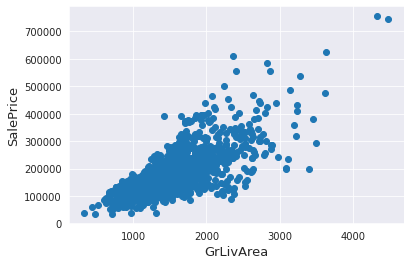

In [42]:
fig, ax = plt.subplots()
ax.scatter(x_train['GrLivArea'], y_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Skewness


**Check Skewness**

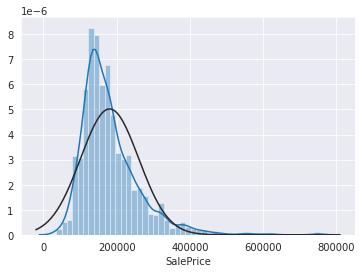

In [43]:
sns.distplot(y_train['SalePrice'] , fit=norm);

** Box-Cox-transformation of the target variable**

In [44]:
from scipy.special import boxcox1p
lam = 0.0
y_train["SalePrice"] = boxcox1p(y_train["SalePrice"],lam)

#train["SalePrice"] = np.log1p(train["SalePrice"])

**Without Skweness**

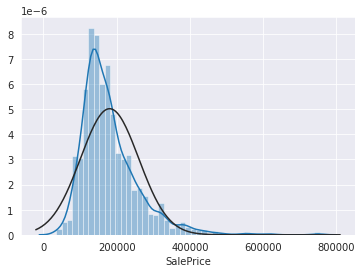

In [45]:
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

## Independent Features

In [46]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train_rows = x_train.shape[0]
x_test_rows = x_test.shape[0]

x_train_test = pd.concat((x_train,x_test)).reset_index(drop=True)

print("x_train_test shape",x_train_test.shape)

x_train shape: (1458, 80)
x_test shape: (1459, 80)
x_train_test shape (2917, 80)


### Missing Data

**Finding Missing Data Features**

In [47]:
missing_data = (x_train_test.isnull().sum() / len(x_train_test)) * 100
missing_data = missing_data.drop(missing_data[missing_data==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :missing_data})

print("Missing Features count:",missing_data.shape)
missing_data.head()

Missing Features count: (34, 1)


,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680


**Imputing missing values**

In [48]:
fill_None = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual',
             'GarageCond', 'GarageType','BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2',
             'BsmtFinType1', 'MasVnrType']

fill_0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
            'GarageCars', 'GarageArea']

fill_mode = ['MSZoning','Electrical', 'KitchenQual', 'Utilities', 'Functional', 'Exterior2nd',
            'Exterior1st', 'SaleType', 'MSZoning' ]

for col in fill_None:
    x_train_test[col] = x_train_test[col].fillna('None')

for col in (fill_0):
    x_train_test[col] = x_train_test[col].fillna(0)

for col in (fill_mode):
    x_train_test[col] = x_train_test[col].fillna(x_train_test[col].mode()[0])


In [49]:
#Group by neighborhood and fill in missing value by the median LotFrontage of each corresponding neighborhood
x_train_test["LotFrontage"] = x_train_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

x_train_test["MasVnrArea"] = x_train_test.groupby("MasVnrType")["MasVnrArea"].transform(
    lambda x: x.fillna(x.mean()))


In [50]:
# for index, row in x_train_test.iterrows():
#   if(pd.isnull(row["GarageType"])):
#     row['GarageFinish'] = 'None'
#     row['GarageQual'] = 'None'
#     row['GarageCond'] = 'None'
#     row['GarageYrBlt'] = 0
#     row['GarageCars'] = 0
#     row['GarageArea'] = 0
#   else:
#     if(pd.isnull(row["GarageArea"])):
#       print("Ho God")

# By correlation between GarageYrBlt YearBuilt
for index, row in x_train_test.iterrows():
  if(pd.isnull(row["GarageYrBlt"])):
    if(pd.isnull(row["YearBuilt"])):
      x_train_test["GarageYrBlt"][index] = 0
    else:
      x_train_test["GarageYrBlt"][index] = x_train_test["YearBuilt"][index]
      

In [51]:
missing_data = (x_train_test.isnull().sum() / len(x_train_test)) * 100
missing_data = missing_data.drop(missing_data[missing_data==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :missing_data})

print("Missing Features count:",missing_data.shape)
missing_data.head(34)

Missing Features count: (0, 1)


,Missing Ratio


Finding Missing Data Features 

In [52]:
missing_data = (x_train_test.isnull().sum() / len(x_train_test)) * 100
missing_data = missing_data.drop(missing_data[missing_data==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :missing_data})

print("Missing Features count:",missing_data.shape)
missing_data.head()

Missing Features count: (0, 1)


,Missing Ratio


### Add&Delete features(FE)

In [53]:
# Adding total sqfootage feature 
x_train_test['TotalSF'] = x_train_test['TotalBsmtSF'] + x_train_test['1stFlrSF'] + x_train_test['2ndFlrSF']

x_train_test['Total_sqr_footage'] = (x_train_test['BsmtFinSF1'] + x_train_test['BsmtFinSF2'] +
                                 x_train_test['1stFlrSF'] + x_train_test['2ndFlrSF'])

x_train_test['Total_Bathrooms'] = (x_train_test['FullBath'] + (0.5 * x_train_test['HalfBath']) +
                               x_train_test['BsmtFullBath'] + (0.5 * x_train_test['BsmtHalfBath']))

x_train_test['YrBltAndRemod'] = x_train_test['YearBuilt'] + x_train_test['YearRemodAdd']

x_train_test['Total_porch_sf'] = (x_train_test['OpenPorchSF'] + x_train_test['3SsnPorch'] +
                              x_train_test['EnclosedPorch'] + x_train_test['ScreenPorch'] +
                              x_train_test['WoodDeckSF'])



In [54]:
# Deleting features
x_test_id = x_test["Id"]
x_train_test = x_train_test.drop("Id" ,axis = 1)
x_train_test = x_train_test.drop(['Utilities'], axis=1)

### Categorical Features



**Numerical categorical variables**

In [55]:
#MSSubClass=The building class
x_train_test['MSSubClass'] = x_train_test['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
x_train_test['OverallCond'] = x_train_test['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
x_train_test['YrSold'] = x_train_test['YrSold'].astype(str)
x_train_test['MoSold'] = x_train_test['MoSold'].astype(str)

**Label Encoding ordering set**

In [56]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(x_train_test[c].values)) 
    x_train_test[c] = lbl.transform(list(x_train_test[c].values))


In [57]:
# For example, note how Street, Alley, Fence ... are encoded (compare with (pre-label encoding) table at the top of the notebook)
x_train_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,Total_sqr_footage,Total_Bathrooms,YrBltAndRemod,Total_porch_sf
0,10,RL,65.000,8450,1,1,3,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,2,4,PConc,2,4,3,2,706.000,6,0.000,150.000,856.000,GasA,0,1,...,0,1710,1.000,0.000,2,1,3,1,2,8,6,0,3,Attchd,2003.000,2,2.000,548.000,5,5,2,0,61,0,0,0,0,3,4,None,0,4,2,WD,Normal,2566.000,2416.000,3.500,4006,61
1,5,RL,80.000,9600,1,1,3,Lvl,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,3,4,CBlock,2,4,1,0,978.000,6,0.000,284.000,1262.000,GasA,0,1,...,0,1262,0.000,1.000,2,0,3,1,3,6,6,1,5,Attchd,1976.000,2,2.000,460.000,5,5,2,298,0,0,0,0,0,3,4,None,0,7,1,WD,Normal,2524.000,2240.000,2.500,3952,298
2,10,RL,68.000,11250,1,1,0,Lvl,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,2,4,PConc,2,4,2,2,486.000,6,0.000,434.000,920.000,GasA,0,1,...,0,1786,1.000,0.000,2,1,3,1,2,6,6,1,5,Attchd,2001.000,2,2.000,608.000,5,5,2,0,42,0,0,0,0,3,4,None,0,11,2,WD,Normal,2706.000,2272.000,3.500,4003,42
3,11,RL,60.000,9550,1,1,0,Lvl,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,3,4,BrkTil,4,1,3,0,216.000,6,0.000,540.000,756.000,GasA,2,1,...,0,1717,1.000,0.000,1,0,3,1,2,7,6,1,2,Detchd,1998.000,3,3.000,642.000,5,5,2,0,35,272,0,0,0,3,4,None,0,4,0,WD,Abnorml,2473.000,1933.000,2.000,3885,307
4,10,RL,84.000,14260,1,1,0,Lvl,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,2,4,PConc,2,4,0,2,655.000,6,0.000,490.000,1145.000,GasA,0,1,...,0,2198,1.000,0.000,2,1,4,1,2,9,6,1,5,Attchd,2000.000,2,3.000,836.000,5,5,2,192,84,0,0,0,0,3,4,None,0,3,2,WD,Normal,3343.000,2853.000,3.500,4000,276


In [58]:
x_train_test.shape

(2917, 83)

### Skewed features

**Finding highly skewed features**

In [59]:
x_train_test.dtypes

MSSubClass             int64
MSZoning              object
LotFrontage          float64
LotArea                int64
Street                 int64
                      ...   
TotalSF              float64
Total_sqr_footage    float64
Total_Bathrooms      float64
YrBltAndRemod          int64
Total_porch_sf         int64
Length: 83, dtype: object

We now determine the skewness of the distributions of the numerical features (int64 and float64).

In [60]:
numeric_feats = x_train_test.dtypes[x_train_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = x_train_test[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [61]:
skewness.shape

(63, 1)

**Box-Cox-Transformation**

In [62]:
skewness = skewness[abs(skewness) > 0.75]   
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #x_train_test[feat] += 1
    x_train_test[feat] = boxcox1p(x_train_test[feat], lam)
    
#x_train_test[skewed_features] = np.log1p(x_train_test[skewed_features])
# of lambda= 0 that is also log transformation

There are 63 skewed numerical features to Box Cox transform


### Dummy categorical features

In [63]:
x_train_test = pd.get_dummies(x_train_test,drop_first=True)
print(x_train_test.shape)

(2917, 204)


In [64]:
x_train_test.head()   # it is interesting to compare this table below with its previous version above

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.886,5.831,19.212,0.730,0.730,1.541,0.000,2.440,1.820,14.188,14.188,8.059,1.194,1.820,1.194,1.820,1.541,1.194,11.170,2.260,0.000,7.483,11.693,0.000,0.730,11.693,11.686,0.000,13.699,0.730,0.000,1.194,0.730,1.541,0.730,1.194,2.603,2.260,0.000,1.541,...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2.056,6.221,19.712,0.730,0.730,1.541,0.000,2.260,2.440,14.145,14.145,0.000,1.541,1.820,1.194,1.820,0.730,0.000,12.063,2.260,0.000,8.898,12.792,0.000,0.730,12.792,0.000,0.000,12.792,0.000,0.730,1.194,0.000,1.541,0.730,1.541,2.260,2.260,0.730,2.056,...,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,2.886,5.915,20.347,0.730,0.730,0.000,0.000,2.440,1.820,14.184,14.186,7.647,1.194,1.820,1.194,1.820,1.194,1.194,10.200,2.260,0.000,9.917,11.892,0.000,0.730,11.892,11.725,0.000,13.832,0.730,0.000,1.194,0.730,1.541,0.730,1.194,2.260,2.260,0.730,2.056,...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,3.011,5.685,19.692,0.730,0.730,0.000,0.000,2.440,1.820,14.048,14.136,0.000,1.541,1.820,1.820,0.730,1.541,0.000,8.274,2.260,0.000,10.468,11.354,1.194,0.730,12.014,11.354,0.000,13.711,0.730,0.000,0.730,0.000,1.541,0.730,1.194,2.440,2.260,0.730,1.194,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2.886,6.315,21.325,0.730,0.730,0.000,0.000,2.603,1.820,14.183,14.183,9.392,1.194,1.820,1.194,1.820,0.000,1.194,10.971,2.260,0.000,10.221,12.511,0.000,0.730,12.511,12.271,0.000,14.480,0.730,0.000,1.194,0.730,1.820,0.730,1.194,2.750,2.260,0.730,2.056,...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Therefore, the new train and test data sets are:

In [65]:
x_train = x_train_test[:x_train_rows]
x_test = x_train_test[x_train_rows:]


In [66]:
x_train.shape

(1458, 204)

In [67]:
y_train

,SalePrice
0,12.248
1,12.109
2,12.317
3,11.849
4,12.429
...,...
1455,12.073
1456,12.255
1457,12.493
1458,11.864


In [68]:
x_test.shape

(1459, 204)

# Modeling

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, MultiTaskLasso, LassoLars
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.linear_model import ElasticNet, MultiTaskElasticNet

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from math import sqrt

## Base Models

In [70]:
linearRegression = LinearRegression()

In [71]:
lasso = Lasso()
lassoLars = LassoLars()
multiTaskLasso = MultiTaskLasso()

In [72]:
ridge = Ridge()
kernelRidge = KernelRidge() 

In [73]:
elasticNet = ElasticNet()
multiTaskElasticNet = MultiTaskElasticNet()

In [74]:
svr = SVR()

In [75]:
decisionTree =  DecisionTreeRegressor()

In [76]:
randomForest = RandomForestRegressor()


In [77]:
GBoost = GradientBoostingRegressor()

In [78]:
xgb = xgb.XGBRegressor()

In [79]:
lgb = lgb.LGBMRegressor()

## Hyperparameter Tuning

In [80]:
#Lasso
lasso_params = { 
    'alpha': [ 0.0002]
    } 

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=None)
lasso_model = GridSearchCV( estimator=lasso, param_grid=lasso_params, cv=cv )

lasso_model = lasso_model.fit(x_train, y_train)

print(lasso_model.best_score_ * 100)
print(lasso_model.best_estimator_)

91.67416124127195
Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [81]:
#MultiTaskLasso
multiTaskLasso_params = { 
    'alpha': [0.0002]
    } 

cv = KFold(n_splits=5, shuffle=True, random_state=1)
multiTaskLasso_model = GridSearchCV(estimator=multiTaskLasso, param_grid=lasso_params, cv=cv,
              )

multiTaskLasso_model = multiTaskLasso_model.fit(x_train, y_train)

print(multiTaskLasso_model.best_score_ * 100)
print(multiTaskLasso_model.best_estimator_)

91.79494556260413
MultiTaskLasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
               normalize=False, random_state=None, selection='cyclic',
               tol=0.0001, warm_start=False)


In [82]:
#LassoLars
lassoLars_params = { 
    'alpha': [ 0.0002 ]
    } 

cv = KFold(n_splits=5, shuffle=True, random_state=1)
lassoLars_model = GridSearchCV(estimator=lassoLars, param_grid=lasso_params, cv=cv,
              )

lassoLars_model = lassoLars_model.fit(x_train, y_train)

print(lassoLars_model.best_score_ * 100)
print(lassoLars_model.best_estimator_)

91.4350734481745
LassoLars(alpha=0.0002, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
          positive=False, precompute='auto', verbose=False)


In [83]:
#Ridge

ridge_params = { 
    'alpha': [  5.4 ]
    }

cv = KFold(n_splits=5, shuffle=True, random_state=1)
ridge_model = GridSearchCV(estimator=ridge, param_grid=ridge_params, cv=cv)

ridge_model.fit(x_train, y_train)

print(ridge_model.best_score_ * 100)
print(ridge_model.best_estimator_)

91.6431926798375
Ridge(alpha=5.4, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [84]:
#KernelRidge

kernelRidge_params = { 
    'alpha': [7],
    'kernel': ['polynomial']
    }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
kernelRidge_model = GridSearchCV(estimator=kernelRidge, param_grid=kernelRidge_params, cv=cv)

kernelRidge_model.fit(x_train, y_train)

print(kernelRidge_model.best_score_ * 100)
print(kernelRidge_model.best_estimator_)

90.74573670232097
KernelRidge(alpha=7, coef0=1, degree=3, gamma=None, kernel='polynomial',
            kernel_params=None)


In [85]:
#ElasticNet

elasticNet_params = { 
    'alpha': [0.001]
    }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
elasticNet_model = GridSearchCV(estimator=elasticNet, param_grid=elasticNet_params, cv=cv)

elasticNet_model.fit(x_train, y_train)

print(elasticNet_model.best_score_ * 100)
print(elasticNet_model.best_estimator_)

91.56885670918933
ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [86]:
#MultiTaskElasticNet

multiTaskElasticNet_params = { 
    'alpha': [.001],
    'l1_ratio': [0.4] # Should be
    }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
multiTaskElasticNet_model =  GridSearchCV(estimator=multiTaskElasticNet, param_grid=multiTaskElasticNet_params, cv=cv)

multiTaskElasticNet_model.fit(x_train, y_train)

print(multiTaskElasticNet_model.best_score_ * 100)
print(multiTaskElasticNet_model.best_estimator_)

91.57652606502488
MultiTaskElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.4,
                    max_iter=1000, normalize=False, random_state=None,
                    selection='cyclic', tol=0.0001, warm_start=False)


In [87]:
#SVR

svr_params = {
    'C': [ 18.2 ],
    'epsilon': [0.02],
    'kernel': ['poly']
    }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
svr_model =  GridSearchCV(estimator=svr, param_grid=svr_params, cv=cv)

svr_model.fit(x_train, y_train)

print(svr_model.best_score_ * 100)
print(svr_model.best_estimator_)

91.48807291061644
SVR(C=18.2, cache_size=200, coef0=0.0, degree=3, epsilon=0.02, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [88]:
#DecisionTree

decisionTree_params = {
    'criterion' : ['friedman_mse'],
    'splitter' : ['best'],
    'max_depth' : [6],
    'max_features' : ['auto'],
    }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
decisionTree_model =  GridSearchCV(estimator=decisionTree, param_grid=decisionTree_params, cv=cv)

decisionTree_model.fit(x_train, y_train)

print(decisionTree_model.best_score_ * 100)
print(decisionTree_model.best_estimator_)

78.06992255531829
DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [89]:
#RandomForest 86.988864811659, 89.1
randomForest_params = {
  "n_estimators": [ 1000 ],
  "max_features"      : ['sqrt'],
  "min_samples_split" : [4],
  "bootstrap": [False]
  }

cv = KFold(n_splits=5,shuffle=True, random_state=1)
randomForest_model =  GridSearchCV(estimator=randomForest, param_grid=randomForest_params, cv=cv)

randomForest_model.fit(x_train, y_train)

print(randomForest_model.best_score_ * 100)
print(randomForest_model.best_estimator_)

89.10437213199636
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [90]:
#GBoost
# GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
#                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
#                           max_features=None, max_leaf_nodes=None,
#                           min_impurity_decrease=0.0, min_impurity_split=None,
#                           min_samples_leaf=1, min_samples_split=2,
#                           min_weight_fraction_leaf=0.0, n_estimators=100,
#                           n_iter_no_change=None, presort='deprecated',
#                           random_state=None, subsample=1.0, tol=0.0001,
#                           validation_fraction=0.1, verbose=0, warm_start=False)
# 90.57744115467223
#n_estimators 300 90.88860765008269
90.85196866881728

GBoost_params = {
    "n_estimators": [350, 500],
    "learning_rate": [0.1, 0.5]
  }

cv = KFold(n_splits=5)
GBoost_model =  GridSearchCV(estimator=GBoost, param_grid=GBoost_params, cv=cv)

GBoost_model.fit(x_train, y_train)

print(GBoost_model.best_score_ * 100)
print(GBoost_model.best_estimator_)

90.66545943485339
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [91]:
#XGB

# Default Score
# XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0,
#              importance_type='gain', learning_rate=0.1, max_delta_step=0,
#              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#              n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#              silent=None, subsample=1, verbosity=1)


#GBoost 90.75033182424414
#n_estimators 1000 -> 91.20725055569056
#n_estimators 900     91.21
#n_estimators 650     91.22
#gamma 0.01           91.3328644961757
#learning_rate 0.05   91.5152778258778
#learning_rate 0.04   91.58987223363953

#no change: colsample_bytree, colsample_bylevel, colsample_bynode
#no change: scale_pos_weight, min_child_weight
#no change: reg_alpha, reg_lambda but not gamma

#Effective: n_estimators, learning_rate, gamma 


xgb_params = {
    "n_jobs" : [-1],
    "n_estimators" : [650],
    "gamma" : [0.01],
    "learning_rate" : [0.04],
    "reg_alpha" : [0],         # no change
    "reg_lambda" : [1],        # no change
    "colsample_bytree" : [1],  # no change 
    "colsample_bylevel" : [1], # no change
    "max_depth" : [3],         # no change 

}

cv = KFold(n_splits=5, shuffle=True, random_state=1)
xgb_model =  GridSearchCV(estimator=xgb, param_grid= xgb_params, cv=cv)

xgb_model.fit(x_train, y_train)

print(xgb_model.best_score_ * 100)
print(xgb_model.best_estimator_)

[04:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
91.58987223363953
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
            

In [92]:
# LightGBM
# objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11

# LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#               importance_type='split', learning_rate=0.1, max_depth=-1,
#               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
#               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#                   89.90701906606753
#n_estimators  90   89.92821579095121
#learning_rate 0.09 90.14320998235

#no change max_depth, min_child_samples

lgb_params = {
    "n_jobs": [-1],
    "n_estimators": [90],
    "learning_rate": [0.09],
}

cv = KFold(n_splits=5)
lgb_model =  GridSearchCV(estimator=lgb, param_grid= lgb_params, cv=cv)

lgb_model.fit(x_train, y_train)

print(lgb_model.best_score_ * 100)
print(lgb_model.best_estimator_)

90.14320998235
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.09, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [93]:
#### FOR COLLECTING ALL PAREMS ONE PLACE AND HP TUNING IN LOOP FOR ALL MODELS

# regressors = [ linearRegression, decisionTree, randomForest, lasso, kernalRidge, elasticNet,GBoost, model_xgb, model_lgb]
# 
# grids = [linearRegression_params,decisionTree_params,randomForest_params,lasso_params,kernalRidge_params,elasticNet_params,
#          GBoost_params, xgb_params, lgb_params]

# scores = []

# #for index, regressor in enumerate(regressors):
#     #rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# kf = KFold(n_splits=5, shuffle=True, random_state=1)

# regressor_gridSCV = GridSearchCV(estimator=lasso,
#               param_grid=lasso_params, n_jobs=-1, cv=kf,  
#               scoring='neg_mean_squared_error')

# regressor_gridSCV.fit(x_train, y_train)
# regressor_gridSVC.best_params_
# #    score = regressor_gridSCV.score(x_train, y_train).mean()
# #    print(score)
# #    scores.append(scores)

# #print(scores)

## Define cross validation strategy

In [94]:
## Stacking Averaged models score: 0.1123 -> 0.1116 after adding RobustScaer()
## RobustScaler() should be hear because GridSearch won't work with make_pipeline

lasso_model = make_pipeline(RobustScaler(), lasso_model)
elasticNet_model = make_pipeline(RobustScaler(), elasticNet_model)

In [95]:
#Validation function

n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(x_train)
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(rmse)
    return(rmse)

## Base models scores

In [96]:
models = [ "Lasso", "MultiTaskLasso", "LassoLars",
          "Ridge", "Kernel Ridge",
          "Elastic Net", "MultiTaskElasticNet",
          "Decision Tree",
          "Random Forest", "GBoost", "XGBoost", "LGBoost"]

regressors = [ lasso_model, multiTaskLasso_model, lassoLars_model,
              ridge_model,  kernelRidge_model,
              elasticNet_model, multiTaskElasticNet_model, 
              decisionTree_model,
              randomForest_model, GBoost_model, xgb_model, lgb_model ]
scores = []


for index, regressor in enumerate(regressors):
  scores.append( rmsle_cv(regressor).mean() )

model_scores = pd.DataFrame({
    'Model': models,
    'Score': scores})

model_scores=model_scores.sort_values(by='Score', ascending=True).reset_index(drop=True)

[0.10692112 0.11756949 0.12655943 0.10754507 0.11278187]
[0.10746652 0.11751687 0.12903896 0.11046067 0.11166367]
[0.11086208 0.12069051 0.12686635 0.11193806 0.11208569]
[0.10876578 0.12087347 0.12864775 0.11135606 0.11295114]
[0.11129161 0.13430756 0.13168496 0.11518272 0.11904108]
[0.11031811 0.11699728 0.12490795 0.10671368 0.11164981]
[0.11080836 0.11859743 0.12725132 0.11083417 0.11221119]
[0.18604591 0.18740411 0.17989704 0.18031883 0.1872629 ]
[0.12546538 0.13804672 0.14013106 0.12846237 0.12951942]
[0.12073972 0.12834322 0.12888695 0.11321359 0.11796632]
[04:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:00] WARNING: /workspace/src/objective/regr

In [97]:
model_scores

,Model,Score
0,Elastic Net,0.114
1,Lasso,0.114
2,MultiTaskLasso,0.115
3,MultiTaskElasticNet,0.116
4,LassoLars,0.116
5,Ridge,0.117
6,XGBoost,0.120
7,GBoost,0.122
8,Kernel Ridge,0.122
9,LGBoost,0.125


## Ensembling

**Stacking**

In [98]:
from sklearn.ensemble import StackingRegressor

estimators = [ ('elasticNet', elasticNet_model), ('ridge', kernelRidge_model), ('gboost', GBoost_model) ]
final_estimator = lasso_model

stacked_models = StackingRegressor( estimators=estimators, final_estimator=final_estimator )

score = rmsle_cv(stacked_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[0.10887306 0.11567466 0.12101917 0.10274004 0.10825749]
Stacking Averaged models score: 0.1113 (0.0064)


**Weighted Average**

In [99]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

 Final Training and Prediction

We will have to invert the Box-Cox transform above to be able to submit the predictions from the test data

**StackedRegressor**:

In [100]:
stacked_models.fit(x_train, y_train)
stacked_models_y_train_pred = stacked_models.predict(x_train)
stacked_models_y_test_pred = np.expm1(stacked_models.predict(x_test))
print(rmsle(y_train, stacked_models_y_train_pred))

0.07705118773595805


**XGBoost**:

In [101]:
xgb_model.fit(x_train, y_train)
xgb_y_train_pred = xgb_model.predict(x_train)
xgb_y_test_pred = np.expm1(xgb_model.predict(x_test))
print(rmsle(y_train, xgb_y_train_pred))

[05:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.06368622254019249


**LightGBM**:

In [102]:
lgb_model.fit(x_train, y_train)
lgb_y_train_pred = lgb_model.predict(x_train)
lgb_y_test_pred = np.expm1(lgb_model.predict(x_test))
print(rmsle(y_train, lgb_y_train_pred))

0.048011418455771566


In [103]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_models_y_train_pred*0.60 +
               xgb_y_train_pred*0.20 + lgb_y_train_pred*0.20 ))

RMSLE score on train data:
0.06573838313232286


**Ensemble prediction**:

In [104]:
ensemble = stacked_models_y_test_pred*0.70 + xgb_y_test_pred*0.15 + lgb_y_test_pred*0.15

#Submission

In [105]:
sub = pd.DataFrame()
sub['Id'] = x_test_id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

Sumbission-1  Rank 2740 

Sumbission-2  Rank 1299 Added more linear algorithems

Sumbission-3  Rank 376  Added Hyperparameter Tuning and stacking

Submission-4  Rank 263  Added 4 new featrues
